[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/Virus_DEseq.ipynb)

In [1]:
# import packages

import os, sys
sys.path.append('../')
from pathlib import Path

import time

# numbers
import numpy as np
import pandas as pd

# sc
import anndata
import scanpy as sc

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import statsmodels.stats.multitest

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

In [2]:
os.chdir('/home/coakes/rat/')
from rat_friend import *
os.chdir('/home/coakes/virus_rat/')

In [3]:
color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
color_dict = {}

for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# Load Data

## Load virus dataset

In [4]:
virus_adata = anndata.read_h5ad("/home/coakes/virus_rat/virus_post_qc.h5ad")
virus_adata.obs.time = virus_adata.obs.time.astype('int')
virus_adata = virus_adata[~virus_adata.obs['time'].isna()]
virus_adata = virus_adata[:,~virus_adata.var.contaminate]
virus_adata.obs['lifetime'] = [8 if x == 0 else x for x in virus_adata.obs.time.values]
adata = virus_adata[virus_adata.obs['lifetime']==8]
adata

/tmp/ipykernel_2034317/3043539459.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  virus_adata.obs['lifetime'] = [8 if x == 0 else x for x in virus_adata.obs.time.values]


View of AnnData object with n_obs × n_vars = 353 × 30758
    obs: 'barcode', 'index', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'old_tissue', 'lifetime'
    var: 'rep_ID', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'contaminate', 'known', 'n_counts'

In [5]:
adata = adata[:,adata.X.sum(axis=0) > 1]
# remove tissues that cause problems for inference due to missing values
adata = adata[[x not in ['VENACV', 'TESTES', 'OVARY'] for x in adata.obs.tissue.values]]
adata

View of AnnData object with n_obs × n_vars = 313 × 19128
    obs: 'barcode', 'index', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'old_tissue', 'lifetime'
    var: 'rep_ID', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'contaminate', 'known', 'n_counts'

## Load Rat Data

In [6]:
rat_adata = anndata.read_h5ad("/home/coakes/rat/omics_adata/rat_RNA_meta.h5ad")
rat_adata.layers['counts'] = rat_adata.X
rat_adata

AnnData object with n_obs × n_vars = 861 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [7]:
nid_rat_adata = sum_by(rat_adata, 'nid')
nid_rat_adata.obs = pd.merge(nid_rat_adata.obs.reset_index(names='nid'), rat_adata.obs.groupby('nid').first()[['sex', 'time']].reset_index())
nid_rat_adata

AnnData object with n_obs × n_vars = 50 × 24770
    obs: 'nid', 'sex', 'time'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'

# Find differential viruses between time 0 and 8

## Generate Deseq Model 

In [8]:
inference = DefaultInference()
dds = DeseqDataSet(
    counts=np.round(adata.X.toarray()),
    metadata=adata.obs[['nid', 'tissue', 'sex', 'time']],
    # setting intercept as 0 because expectation is no virus expression
    design='~0+(tissue + sex) * (time)',
    inference=inference,
)
dds.deseq2()

Fitting size factors...
... done in 0.10 seconds.

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:379: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:233: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:231: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:383: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pydeseq2/utils.py:386: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packag

## Run Statistical Tests

In [9]:
contrast_vector = np.ones(len(dds.obsm['design_matrix'].columns)) * np.array([('time' == x ) for x in dds.obsm['design_matrix'].columns.values])
# intercept is left at 0 because the assumption that there should be no expression is reasonable
contrast_vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
stat_res = DeseqStats(dds, 
                                 contrast=contrast_vector, 
                                 inference=inference)
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
       baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0      0.036071        0.013853  1.484502  0.009331  0.992555  0.999998
1      0.268704       -0.015844  1.484254 -0.010675  0.991483  0.999998
2      0.933316       -0.248279  0.766024 -0.324114  0.745852  0.999998
3      0.262135        0.018158  1.474521  0.012315  0.990175  0.999998
4      3.171994       -0.084673  0.286910 -0.295121  0.767902  0.999998
...         ...             ...       ...       ...       ...       ...
19123  0.010673       -0.008058  1.484481 -0.005428  0.995669  0.999998
19124  0.005747        0.006014  1.484567  0.004051  0.996768  0.999998
19125  0.019320       -0.011110  1.484465 -0.007484  0.994029  0.999998
19126  0.005789        0.001323  1.484535  0.000891  0.999289  0.999998
19127  0.021500        0.013557  1.484615  0.009

... done in 1.56 seconds.



In [11]:
res = stat_res.results_df
res.index = adata.var.rep_ID.values
res.sort_values(['padj'], ascending=True).iloc[0:10,:]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
u234187,1.280187,-43.280851,4.435675e-01,-9.757444e+01,0.000000,0.000000
u125175,0.928107,-43.280851,3.930260e-46,-1.101221e+47,0.000000,0.000000
u295937,0.019833,-0.011205,1.484579e+00,-7.547559e-03,0.993978,0.999998
u295940,0.122492,0.044500,1.484716e+00,2.997227e-02,0.976089,0.999998
u295973,0.173364,0.057125,1.484577e+00,3.847913e-02,0.969306,0.999998
u295983,0.005534,-0.003217,1.484552e+00,-2.166690e-03,0.998271,0.999998
u295988,0.002620,-0.001022,1.484526e+00,-6.883690e-04,0.999451,0.999998
u296056,0.003706,0.003669,1.484554e+00,2.471177e-03,0.998028,0.999998
u296061,0.277703,0.000188,1.198131e+00,1.567311e-04,0.999875,0.999998
u296066,0.011207,0.010717,1.484596e+00,7.219092e-03,0.994240,0.999998


## Plot Results

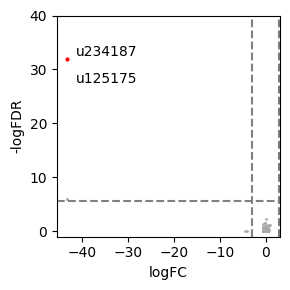

In [12]:
df = res
df['logFC'] = df['log2FoldChange']
df['adj.P.Val'] = df['pvalue']

FC = 3
    
plt.figure(figsize=(3, 3))
plt.scatter(x=df['logFC'],y=df['adj.P.Val'].apply(lambda x:-np.log10(x+.000001)),s=1,label="Not significant", color = 'darkgrey')

# highlight down- or up- regulated genes
down = df[(df['logFC']<=-FC)&(df['adj.P.Val']<=0.05)]
up = df[(df['logFC']>=FC)&(df['adj.P.Val']<=0.05)]


plt.scatter(x=down['logFC'],y=down['adj.P.Val'].apply(lambda x:-np.log10(x+1e-32)),s=3,label="Down-regulated",color="red")
plt.scatter(x=up['logFC'],y=up['adj.P.Val'].apply(lambda x:-np.log10(x+1e-30)),s=3,label="Up-regulated",color="red")
texts=[]
for i,r in up.iterrows():
    texts.append(plt.text(x=r['logFC'],y=-np.log10(r['adj.P.Val']),s=i))
ad=0
for i,r in down.iterrows():
    texts.append(plt.text(x=r['logFC']+2,y=-np.log10(r['adj.P.Val']+1e-30)-3-5*ad,s=i, va='bottom', ha='left'))
    ad-=1
    #break
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-FC,color="grey",linestyle="--")
plt.axvline(FC,color="grey",linestyle="--")
plt.axhline(-np.log10(.05/df.shape[0]),color="grey",linestyle="--")
#adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5), expand = (1.5, 1.5))
plt.ylim([-1, 40])
plt.tight_layout()
plt.savefig('figures_final/fig_3b.png')
plt.show()



# Correlation of Differentially "Expressed" Virus to genes

## Subset to specific Virus

In [13]:
vir = 'u234187'

small_vir_adata = virus_adata[:,virus_adata.var.rep_ID == vir]
small_nid_vir_adata = sum_by(small_vir_adata, 'nid')
small_nid_vir_adata.obs = pd.merge(small_nid_vir_adata.obs.reset_index(names='nid'), small_vir_adata.obs.groupby('nid').first()[['sex', 'time', 'lifetime']].reset_index())
small_nid_vir_adata

AnnData object with n_obs × n_vars = 50 × 1
    obs: 'nid', 'sex', 'time', 'lifetime'
    var: 'rep_ID', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'contaminate', 'known', 'n_counts'

In [14]:
small_rat_adata = rat_adata.copy()
small_rat_adata = small_rat_adata[~small_rat_adata.obs.tissue.isin(['VENACV', 'ADRNL','TESTES', 'OVARY'])]
small_nid_rat_adata = sum_by(small_rat_adata, 'nid')
small_nid_rat_adata.obs = pd.merge(small_nid_rat_adata.obs.reset_index(names='nid'), small_rat_adata.obs.groupby('nid').first()[['sex', 'time', 'calculated.variables.vo2_max_change']].reset_index())
small_nid_rat_adata

AnnData object with n_obs × n_vars = 50 × 24770
    obs: 'nid', 'sex', 'time', 'calculated.variables.vo2_max_change'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'

In [15]:
count_data = pd.DataFrame(small_nid_rat_adata.X,
            columns = small_nid_rat_adata.var.gene_id)

vir_counts = pd.DataFrame({
    'vir_counts' : small_nid_vir_adata.X.toarray().transpose().tolist()[0]
})

vir_correlations = count_data.corrwith(vir_counts['vir_counts'])
rat_analysis_df = pd.DataFrame({
    'vir_corr' : vir_correlations.values,
    'gene_counts' : count_data.sum(),
    'gene_name' : small_nid_rat_adata.var.X3
})
rat_analysis_df = rat_analysis_df[~rat_analysis_df['vir_corr'].isna()]
rat_analysis_df.head()

/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,vir_corr,gene_counts,gene_name
ENSRNOG00000000001,0.212593,18586.0,Arsj
ENSRNOG00000000007,0.064487,575494.0,Gad1
ENSRNOG00000000008,0.005969,34046.0,Alx4
ENSRNOG00000000009,0.046696,877.0,Tmco5b
ENSRNOG00000000010,0.044263,135064.0,Cbln1


## Calculate p-value and adjust for multiple hypothesis testing

In [16]:
rat_analysis_df['p_val'] = rat_analysis_df.vir_corr.apply(lambda x: 2*scipy.stats.beta(small_nid_rat_adata.shape[0]/2 -1, small_nid_rat_adata.shape[0]/2 -1, loc=-1, scale=2).cdf(-abs(x)))
rat_analysis_df['p_val_adj'] = statsmodels.stats.multitest.multipletests(rat_analysis_df['p_val'],
                                          method='bonferroni')[1]
print(rat_analysis_df.shape)
rat_analysis_df.sort_values(['p_val'], ascending=True).iloc[0:10,:]

(24695, 5)


,vir_corr,gene_counts,gene_name,p_val,p_val_adj
ENSRNOG00000066563,0.999799,1.0,NaN,3.492722e-83,8.625277e-79
ENSRNOG00000069751,0.782814,4124.0,NaN,1.864505e-11,4.604396e-07
ENSRNOG00000007468,0.771550,827.0,Ifng,5.463034e-11,1.349096e-06
ENSRNOG00000066796,0.760533,6619.0,LOC691815,1.476291e-10,3.645702e-06
ENSRNOG00000070192,0.756307,5413.0,NaN,2.131595e-10,5.263974e-06
ENSRNOG00000063131,0.699416,2.0,Or4x6,1.599741e-08,3.950560e-04
ENSRNOG00000066828,0.699416,2.0,LOC102551431,1.599741e-08,3.950560e-04
ENSRNOG00000065874,0.669742,7.0,NaN,1.044984e-07,2.580588e-03
ENSRNOG00000056574,0.654947,7966.0,Tigit,2.466164e-07,6.090192e-03
ENSRNOG00000063672,0.638029,1884.0,NaN,6.226342e-07,1.537595e-02


## Subset for genes both significantly correlated with virus and found to be significant in the original analysis

In [17]:
filtered_df = rat_analysis_df[rat_analysis_df.p_val_adj < .05]
print(filtered_df.shape)
os.chdir('/home/coakes/rat/')
filtered_df_old = filtered_df[genes_in_original(filtered_df.index.values,og_supp_table =2)]
os.chdir('/home/coakes/virus_rat/')
print(filtered_df_old.shape)
filtered_df_old.sort_values(['p_val'], ascending=True).iloc[0:10,:]

(11, 5)


/home/coakes/rat/rat_friend.py:39: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  og_de = pd.read_csv(og_supp_table_path+f'og_supp{og_supp_table}.csv', skiprows = 18)


(1, 5)


,vir_corr,gene_counts,gene_name,p_val,p_val_adj
ENSRNOG00000056574,0.654947,7966.0,Tigit,2.466164e-07,0.00609


### Plot Gene of interest versus virus

In [18]:
gene = filtered_df_old.sort_values(['p_val'], ascending=True).index[0]
gene

'ENSRNOG00000056574'

In [19]:
comp_df = pd.DataFrame({
    gene : small_nid_rat_adata[:,small_nid_rat_adata.var.index == gene].X.transpose().tolist()[0],
    vir : small_nid_vir_adata[:,small_nid_vir_adata.var.rep_ID == vir].X.toarray().transpose().tolist()[0],
    'nid' : small_nid_rat_adata.obs.nid.values,
    'vir_nid' : small_nid_vir_adata.obs.nid.values,
    'sex' : small_nid_rat_adata.obs.sex.values,
    'time' : small_nid_rat_adata.obs.time.values,
    'vo2_max' : small_nid_rat_adata.obs['calculated.variables.vo2_max_change'].values
})

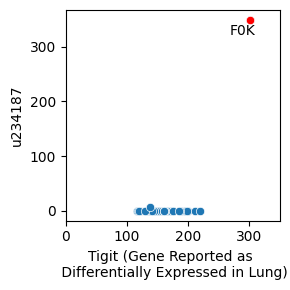

In [20]:
plt.figure(figsize=(3, 3))
sns.scatterplot(comp_df, x = gene, y = vir)
sns.scatterplot(comp_df[comp_df.nid == 'F0K'], x = gene, y = vir, color = 'red')
texts=[]
name_df = comp_df[comp_df.nid == 'F0K'].set_index('nid')
for i,r in name_df.iterrows():
    texts.append(plt.text(x=r[gene]-25,y=r[vir]-30,s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.xlim([0, 350])
plt.xlabel('Tigit (Gene Reported as \n Differentially Expressed in Lung)')
plt.tight_layout()
plt.savefig('figures_final/fig_3d.png')
plt.show()

### Change in V02 Max of time 0 individuals

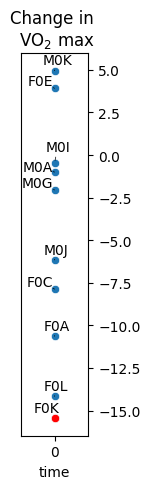

In [21]:
plt.figure(figsize=(1.5, 5))
small_df = comp_df[comp_df.time.isin(['0'])].set_index('nid')
small_df['time'] = small_df.time.cat.remove_unused_categories()
ax = sns.scatterplot(small_df, x = 'time', y = 'vo2_max', alpha=1)
ax = sns.scatterplot(small_df[small_df.index == 'F0K'], x = 'time', y = 'vo2_max', color = 'red', alpha=1)
texts = []
red_texts = []
for i,r in small_df.iterrows():
    if i == 'F0K': 
        red_texts.append(plt.text(x=r['time'],y=r['vo2_max'],s=i, ha = 'right', va = 'bottom'))
    else:
        texts.append(plt.text(x=r['time'],y=r['vo2_max'],s=i, ha = 'right', va = 'bottom'))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5), expand = (1.85, 1))
adjust_text(red_texts,arrowprops=dict(arrowstyle="-", color='red', lw=0.5), expand = (1.85, 1))
plt.title('Change in \n VO$_2$ max')
plt.ylabel(None)
ax.yaxis.tick_right()
#ax.yaxis.set_label_position('right')
plt.tight_layout()
plt.savefig('figures_final/fig_3e.png')
plt.show()

## Plot Expression of Virus of Interest across tissues

In [22]:
adata.var[adata.var.rep_ID.isin(['u125175','u234187'])]

,rep_ID,phylum,class,order,family,genus,species,contaminate,known,n_counts
genes,,,,,,,,,,
u125175,u125175,.,.,.,.,.,.,False,False,2538.82900
u234187,u234187,.,.,.,.,.,.,False,False,356.51249


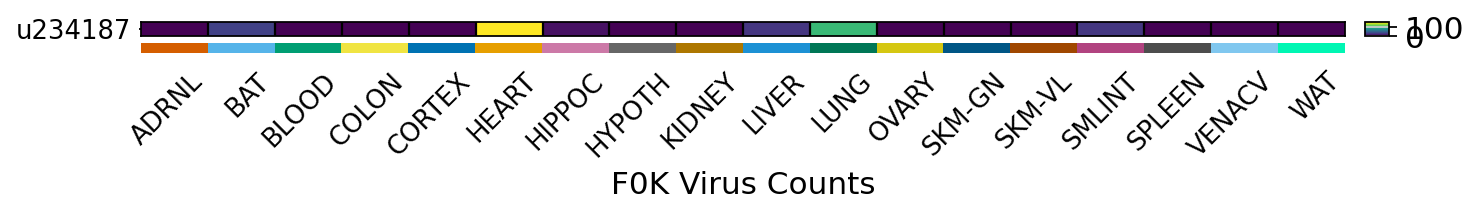

In [37]:
filtered_res = res[res.padj < .05]
virus_adata.obs['F0K Virus Counts'] = virus_adata.obs.tissue
sc.pl._utils._set_colors_for_categorical_obs(virus_adata, 'F0K Virus Counts', palette = color_dict)
sc.set_figure_params(figsize=(2, 8.5))
hmp = sc.pl.heatmap(virus_adata[virus_adata.obs.nid == 'F0K'], 'u234187', groupby = 'F0K Virus Counts', log=False, 
                    use_raw = False, swap_axes = True,
             show = False)
ax = hmp["groupby_ax"]
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
ax.figure.savefig('figures_final/fig_3c.png', bbox_inches = "tight")